# On Similarity Measures for Spike Trains

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def modulo_with_offset(x, modulo, offset=0.0):
    """
    Compute the modulo operation with an offset.
    """
    return (x - offset) % modulo + offset

## Cyclic Distance Function

In [4]:
def cyclic_distance(x1, x2, modulo):
    """
    Compute the pointwise cyclic distances between two arrays of points x1 and x2 on a circle of given modulo.
    """
    x1_x2 = np.abs(x1 % modulo - x2 % modulo)
    return np.minimum(x1_x2, modulo - x1_x2)

In [5]:
cyclic_distance(np.array([0.1, 0.2, 0.3]), np.array([0.9, 0.8, 0.7]), 1.0)

array([0.2, 0.4, 0.4])

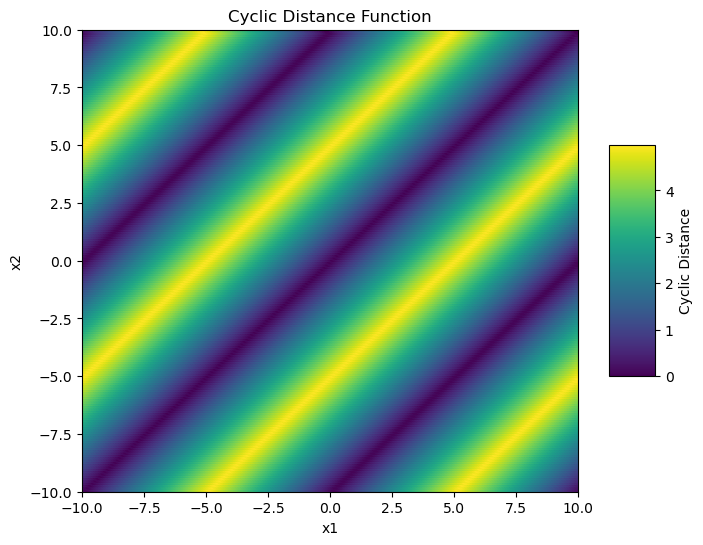

In [6]:
period = 10.0

x = np.linspace(-period, period, 200)
y = np.linspace(-period, period, 200)
X, Y = np.meshgrid(x, y)
# Z = cyclic_distance(X, Y, period)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the surface.
ax.scatter(X, Y, c=cyclic_distance(X, Y, period), s=50, edgecolors='none')
ax.set_xlim(-period, period)
ax.set_ylim(-period, period)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Cyclic Distance Function')
cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Cyclic Distance')

plt.show()

## The Kernel

When comparing a spike train with a reference, each spike is compared to the closest spike in the reference, using a kernel function.
This kernel acts as follows:
- If the spike is within a cyclic distance of 1.0 from the closest spike in the reference, the kernel returns this distance.
- If the spike is further than 1.0, the kernel returns 0.

In [7]:
def kernel(times, rf_times, period, axis=None):
    """
    Compute the kernel function for a given set of times and reference spike times.
    """
    # dist = cyclic_distance(f_times[:,None], times[None, :], period)
    # return 2 * np.min(dist, axis=0).clip(max=0.5) # dissimilarity measure
    return 1.0 - 2 * np.min(
        cyclic_distance(rf_times, times, period), axis=axis
    ).clip(
        max=0.5
    )  # similarity measure

In [8]:
period = 10.0
n_f_times = 8
f_times = np.random.uniform(0.0, period, n_f_times)

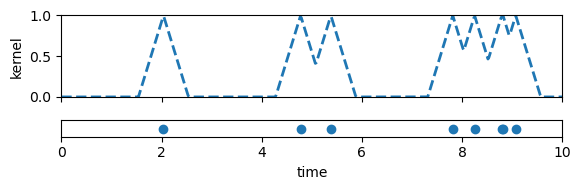

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(6, 2), sharex=True, height_ratios=[1, 0.2])

times = np.linspace(0, period, 500)

axes[0].plot(times, kernel(times[:, None], f_times[None, :], period, axis=1), color='C0', linestyle='--', linewidth=2)
axes[0].set_ylabel('kernel')
axes[0].set_ylim(0, 1)

axes[1].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[1].set_yticks([])

axes[-1].set_xlim(0, period)
axes[-1].set_xlabel('time')

fig.tight_layout()
plt.show()

## The Similarity Measures

When comparing a spike train with a reference, two aspects should be considered:
- How precise the spikes are in comparison to the reference, disregarding the false negatives (i.e., missing spikes).
- How good is the recall from the reference, disregarding the false positives (i.e., spurious spikes).

These two aspects can be measured using the two following measures:
- **Precision**: The average score of the spikes in the spike train to the closest spike in the reference.
- **Recall**: The average score of the spikes in the reference to the closest spike in the spike train.

Moreover, since a global adjustment is not relevant, the best temporal adjustment of the spike train with respect to the reference should be considered.
Due to the special shape of the kernel, the best temporal adjustment can be searched over the ones that perfectly aligns one spike in the spike train with one spike in the reference.

## Single Channel Spike Train

In [10]:
period = 10.0

n_r_f_times = 3
r_f_times = np.random.uniform(0.0, period, n_r_f_times)

n_f_times = 5
f_times = np.random.uniform(0.0, period, n_f_times)

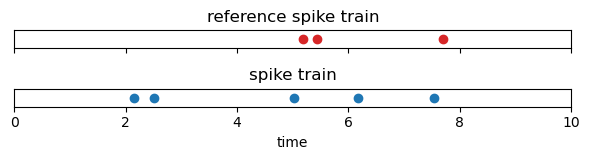

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(6, 1.7), sharex=True)

axes[0].scatter(r_f_times, np.zeros_like(r_f_times), c='C3')
axes[0].set_title("reference spike train")
axes[0].set_yticks([])
axes[0].set_xlim(0, period)

axes[1].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[1].set_title("spike train")
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_xlabel('time')

fig.tight_layout()
plt.show()

### Precision

It measures how precise the spikes in the spike train are with respect to the reference.
The false positives (= spurious spikes) are highly detrimental to this measure.
If the spike train has no spikes, the precision is 1.0.

In [12]:
if n_r_f_times > 0 and n_f_times > 0:
    adjustment = np.linspace(-period/2, period/2, 500)
    scores = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=2), axis=1).squeeze()
elif n_f_times == 0:
    adjustment = np.array([-period/2, period/2])
    scores = np.ones_like(adjustment)
else:
    adjustment = np.array([-period/2, period/2])
    scores = np.zeros_like(adjustment)

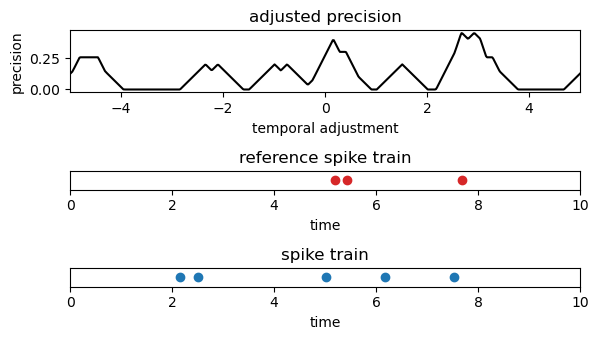

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(6, 3.5), height_ratios=[1, 0.3, 0.3])

axes[0].plot(adjustment, scores, color='k')
# for s in modulo_with_offset((f_times[None, :] - r_f_times[:, None]).flatten(), period, -period/2):
#     axes[0].axvline(s, color='C7', alpha=0.2, linestyle='--')

axes[0].set_title('adjusted precision')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('precision')
axes[0].set_xlim(-period/2, period/2)
# axes[0].set_ylim(0, 1)

axes[1].scatter(r_f_times, np.zeros_like(r_f_times), c='C3')
axes[1].set_xlabel('time')
axes[1].set_title('reference spike train')
axes[1].set_yticks([])
axes[1].set_xlim(0, period)

axes[2].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[2].set_xlabel('time')
axes[2].set_title('spike train')
axes[2].set_yticks([])
axes[2].set_xlim(0, period)

fig.tight_layout()
plt.show()

In [14]:
adjustment = np.linspace(-period/2, period/2, 500)
if n_r_f_times > 0 and n_f_times > 0:
    adjustment = (r_f_times[None, :] - f_times[:, None]).flatten()
    scores = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=2), axis=1).squeeze()
    imax = np.argmax(scores)
    print(f'The best temporal adjustment of the given spikes with the reference ones is {adjustment[imax]:.3f}, resulting in a recall of {scores[imax]:.3f}.')
elif n_f_times == 0:
    imax = None
    print('Without any spikes in the spike train, the precision is 1.0 (no spurious spikes).')
else:
    imax = None
    print('Without any spikes in the reference spike train, the precision is 0.0 (all spikes are spurious).')

The best temporal adjustment of the given spikes with the reference ones is 2.925, resulting in a recall of 0.451.


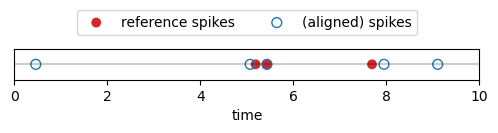

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 0.4))

ax.axhline(0, color='k', alpha=0.2) 
ax.scatter(r_f_times, np.zeros_like(r_f_times), facecolors='C3', edgecolors='none', s=50, label='reference spikes')
ax.scatter((f_times + adjustment[imax]) % period if imax is not None else f_times, np.zeros_like(f_times), facecolors='none', edgecolors='C0', s=50, label='(aligned) spikes')

ax.set_xlabel('time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.5), ncol=2)
ax.set_yticks([])
ax.set_xlim(0, period)

plt.show()

### Recall

It measures how well the spikes in the reference are recalled by the spike train.
The false negatives (= missing spikes) are highly detrimental to this measure.
If the reference spike train has no spikes, the recall is 1.0.

In [16]:
if n_r_f_times > 0 and n_f_times > 0:
    adjustment = np.linspace(-period/2, period/2, 500)
    scores = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=1), axis=1).squeeze()
elif n_r_f_times == 0:
    adjustment = np.array([-period/2, period/2])
    scores = np.ones_like(adjustment)
else:
    adjustment = np.array([-period/2, period/2])
    scores = np.zeros_like(adjustment)

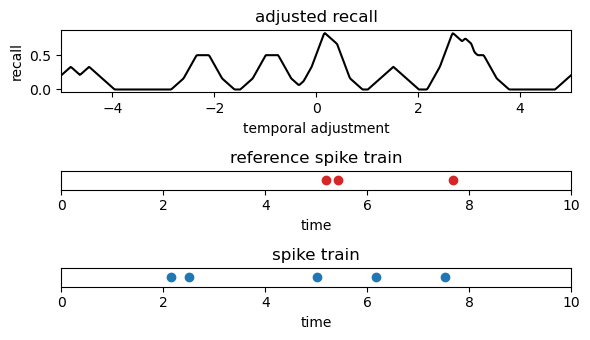

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(6, 3.5), height_ratios=[1, 0.3, 0.3])

axes[0].plot(adjustment, scores, color='k')

axes[0].set_title('adjusted recall')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('recall')
axes[0].set_xlim(-period/2, period/2)
# axes[0].set_ylim(0, 1)

axes[1].scatter(r_f_times, np.zeros_like(r_f_times), c='C3')
axes[1].set_xlabel('time')
axes[1].set_title('reference spike train')
axes[1].set_yticks([])
axes[1].set_xlim(0, period)

axes[2].scatter(f_times, np.zeros_like(f_times), c='C0')
axes[2].set_xlabel('time')
axes[2].set_title('spike train')
axes[2].set_yticks([])
axes[2].set_xlim(0, period)

fig.tight_layout()
plt.show()

In [18]:
adjustment = np.linspace(-period/2, period/2, 500)
if n_r_f_times > 0 and n_f_times > 0:
    adjustment = (r_f_times[None, :] - f_times[:, None]).flatten()
    scores = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=1), axis=1).squeeze()
    imax = np.argmax(scores)
    print(f'The best temporal adjustment of the given spikes with the reference ones is {adjustment[imax]:.3f}, resulting in a recall of {scores[imax]:.3f}.')
elif n_r_f_times == 0:
    imax = None
    print('Without any spikes in the reference spike train, the recall is 1.0 (no missing spikes).')
else:
    imax = None
    print('Without any spikes in the spike train, the recall is 0.0 (all spikes are missing).')

The best temporal adjustment of the given spikes with the reference ones is 0.164, resulting in a recall of 0.832.


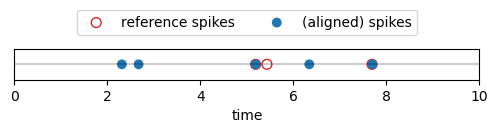

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 0.4))

ax.axhline(0, color='k', alpha=0.2) 
ax.scatter(r_f_times, np.zeros_like(r_f_times), facecolors='none', edgecolors='C3', s=50, label='reference spikes')
ax.scatter((f_times + adjustment[imax]) % period if imax is not None else f_times, np.zeros_like(f_times), facecolors='C0', edgecolors='none', s=50, label='(aligned) spikes')

ax.set_xlabel('time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.5), ncol=2)
ax.set_yticks([])
ax.set_xlim(0, period)

plt.show()

## Multichannel Similarity Measure

Average the precision and recall over all channels.
Global adjustment is determined according to the average.

In [20]:
period = 10.0
n_channels = 3

n_r_f_times = np.random.randint(0, 10, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 10, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

# n_f_times = np.copy(n_r_f_times)
# f_times = [r_f_times_c + np.random.randn(n_r_f_times_c) * 5e-2 for r_f_times_c, n_r_f_times_c in zip(r_f_times, n_r_f_times)]

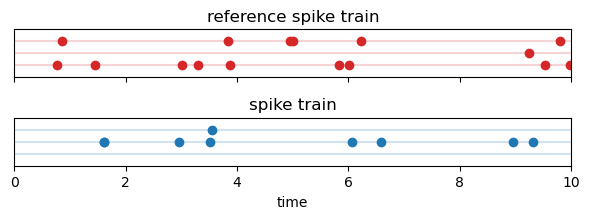

In [21]:

fig, axes = plt.subplots(2, 1, figsize=(6, 2.3), sharex=True)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    axes[0].axhline(c, color='C3', alpha=0.2)
    axes[0].scatter(r_f_times_c, np.full_like(r_f_times_c, c), c='C3')
    
    axes[1].axhline(c, color='C0', alpha=0.2)
    axes[1].scatter(f_times_c, np.full_like(f_times_c, c), c='C0')

axes[0].set_title("reference spike train")
axes[0].set_yticks([])
axes[0].set_xlim(0, period)
axes[0].set_ylim(-1, n_channels)

axes[1].set_title("spike train")
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1, n_channels)
axes[1].set_xlabel('time')

fig.tight_layout()
plt.show()

### Precision

In [22]:
adjustment = np.linspace(-period/2, period/2, 500)
scores = np.mean([np.mean(kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=2), axis=1).squeeze() if f_times_c.size > 0 and r_f_times_c.size > 0 else np.ones_like(adjustment) if f_times_c.size == 0 else np.zeros_like(adjustment) for f_times_c, r_f_times_c in zip(f_times, r_f_times)], axis=0)

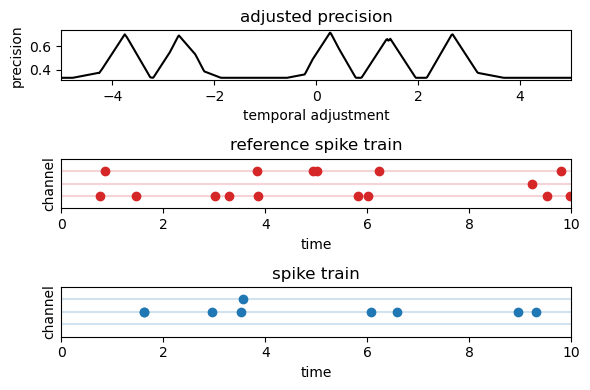

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), height_ratios=[1, 1, 1])

axes[0].plot(adjustment, scores, color='k')
axes[0].set_title('adjusted precision')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('precision')
axes[0].set_xlim(-period/2, period/2)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    axes[1].axhline(c, color='C3', alpha=0.2)
    axes[1].scatter(r_f_times_c, np.full_like(r_f_times_c, c), c='C3')
    
axes[1].set_title("reference spike train")
axes[1].set_xlabel('time')
axes[1].set_ylabel('channel')
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1, n_channels)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):    
    axes[2].axhline(c, color='C0', alpha=0.2)
    axes[2].scatter(f_times_c, np.full_like(f_times_c, c), c='C0')

axes[2].set_title("spike train")
axes[2].set_xlabel('time')
axes[2].set_ylabel('channel')
axes[2].set_yticks([])
axes[2].set_xlim(0, period)
axes[2].set_ylim(-1, n_channels)

fig.tight_layout()
plt.show()

In [24]:
adjustment = modulo_with_offset(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]), period, -period/2)
scores = np.mean([np.mean(kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=2), axis=1).squeeze() if f_times_c.size > 0 and r_f_times_c.size > 0 else np.ones_like(adjustment) if f_times_c.size == 0 else np.zeros_like(adjustment) for f_times_c, r_f_times_c in zip(f_times, r_f_times)], axis=0)
imax = np.argmax(scores)

print(f'The best temporal adjustment is {adjustment[imax]:.3f}, resulting in a precision of {scores[imax]:.3f}.')

The best temporal adjustment is 0.275, resulting in a precision of 0.721.


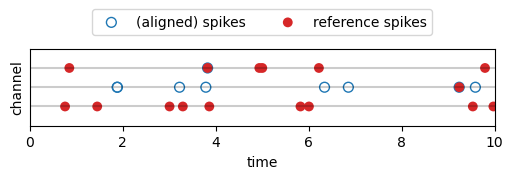

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))

ax.set_xlabel('time')
ax.set_ylabel('channel')

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):   
    ax.axhline(c, color='k', alpha=0.2) 
    ax.scatter((f_times_c + adjustment[imax]) % period, np.full_like(f_times_c, c), facecolors='none', edgecolors='C0', s=50, label='(aligned) spikes' if c==0 else None)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    ax.scatter(r_f_times_c, np.full_like(r_f_times_c, c), facecolors='C3', edgecolors='none', s=50, label='reference spikes' if c==0 else None)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)
ax.set_yticks([])
ax.set_ylim(-1, n_channels)
ax.set_xlim(0, period)


plt.show()

### Recall

In [29]:
adjustment = np.linspace(-period/2, period/2, 500)
scores = np.mean([np.mean(kernel(f_times_c[None, :, None] + adjustment[:, None, None], f_times_c[None, None, :], period, axis=1), axis=1).squeeze() if f_times_c.size > 0 and r_f_times_c.size > 0 else np.ones_like(adjustment) if f_times_c.size == 0 else np.zeros_like(adjustment) for f_times_c, r_f_times_c in zip(f_times, r_f_times)], axis=0)

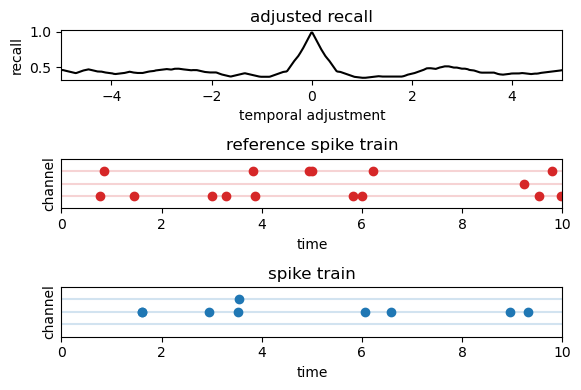

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), height_ratios=[1, 1, 1])

axes[0].plot(adjustment, scores, color='k')
axes[0].set_title('adjusted recall')
axes[0].set_xlabel('temporal adjustment')
axes[0].set_ylabel('recall')
axes[0].set_xlim(-period/2, period/2)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    axes[1].axhline(c, color='C3', alpha=0.2)
    axes[1].scatter(r_f_times_c, np.full_like(r_f_times_c, c), c='C3')
    
axes[1].set_title("reference spike train")
axes[1].set_xlabel('time')
axes[1].set_ylabel('channel')
axes[1].set_yticks([])
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1, n_channels)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):    
    axes[2].axhline(c, color='C0', alpha=0.2)
    axes[2].scatter(f_times_c, np.full_like(f_times_c, c), c='C0')

axes[2].set_title("spike train")
axes[2].set_xlabel('time')
axes[2].set_ylabel('channel')
axes[2].set_yticks([])
axes[2].set_xlim(0, period)
axes[2].set_ylim(-1, n_channels)

fig.tight_layout()
plt.show()

In [ ]:
adjustment = modulo_with_offset(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]), period, -period/2)
scores = np.mean([np.mean(kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=1), axis=1).squeeze() if f_times_c.size > 0 and r_f_times_c.size > 0 else np.ones_like(adjustment) if r_f_times_c.size == 0 else np.zeros_like(adjustment) for f_times_c, r_f_times_c in zip(f_times, r_f_times)], axis=0)
imax = np.argmax(scores)

print(f'The best temporal adjustment is {adjustment[imax]:.3f}, resulting in a recall of {scores[imax]:.3f}.')

The best temporal adjustment is -0.524, resulting in a recall of 0.598.


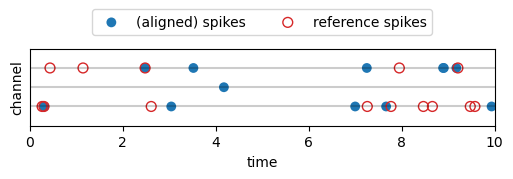

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))

ax.set_xlabel('time')
ax.set_ylabel('channel')

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):   
    ax.axhline(c, color='k', alpha=0.2) 
    ax.scatter((f_times_c + adjustment[imax]) % period, np.full_like(f_times_c, c), facecolors='C0', edgecolors='none', s=50, label='(aligned) spikes' if c==0 else None)

for c, (r_f_times_c, f_times_c) in enumerate(zip(r_f_times, f_times)):
    ax.scatter(r_f_times_c, np.full_like(r_f_times_c, c), facecolors='none', edgecolors='C3', s=50, label='reference spikes' if c==0 else None)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=2)
ax.set_yticks([])
ax.set_ylim(-1, n_channels)
ax.set_xlim(0, period)

plt.show()

# Performant Implementation

How to exploit sparsity in the score?
1. Work with sorted arrays for binary search.
2. The score array has dimension (n_adjustment), we can fill it sequentially.
3. Use binary search to determine the ranges of time differences that are within the kernel. For every time difference, we have the list of indices in adjustment where this time difference is within the kernel.
4. Use np.average with weights the number of spikes in the spike train and the reference.

The algorithm consists of the following steps:
1. Sort the adjustment array. All adjustments are within -period/2 and period/2.
2. For every channel, compute the time difference array, shape (n_r_f_times, n_f_times). Initialize the score array with zeros, shape (n_adjustment,). Using binary search, for each time difference, find the indices (left and right) in the adjustment array where the time difference is eps-close to the adjustment, i.e., dt - eps <= adjustment <= dt + eps (eps is the kernel half-width, e.g., 0.5). Perform the following reduction to update the score array:
    - Precision: min reduction over the r_f_times and sum over the f_times. Then divide by n_f_times.
    - Recall: min reduction over the f_times and sum over the r_f_times. Then divide by n_r_f_times.

In [133]:
np.random.seed(42)  # For reproducibility

period = 10.0

n_r_f_times = 3
r_f_times = np.sort(np.random.uniform(0.0, period, n_r_f_times))

n_f_times = 4
f_times = np.sort(np.random.uniform(0.0, period, n_f_times))

In [137]:
x = np.random.randn(3 ,4)
for x_ in x:
    print(x_)

[ 0.27904129  1.01051528 -0.58087813 -0.52516981]
[-0.57138017 -0.92408284 -2.61254901  0.95036968]
[ 0.81644508 -1.523876   -0.42804606 -0.74240684]


In [ ]:
# First version ran in around 6.5 seconds.
# The best temporal adjustment for precision is -15.140, resulting in a precision of 0.154780.
# The best temporal adjustment for recall is -13.095, resulting in a precision of 0.138089.

np.random.seed(42)  # For reproducibility

period = 100.0
n_channels = 100

n_r_f_times = np.random.randint(0, 50, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 50, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

precision, adjustment = compute_score(f_times, r_f_times, period)
iprmax = np.argmax(precision)

print(
    f"The best temporal adjustment for precision is {adjustment[iprmax]:.3f}, resulting in a precision of {precision[iprmax]:.6f}."
)

recall, adjustment = compute_score(r_f_times, f_times, period)
ircmax = np.argmax(recall)
print(
    f"The best temporal adjustment for recall is {adjustment[ircmax]:.3f}, resulting in a precision of {recall[ircmax]:.6f}."
)

The best temporal adjustment for precision is -15.140, resulting in a precision of 0.154780.
The best temporal adjustment for recall is -13.095, resulting in a precision of 0.138089.


In [ ]:
def compute_score(f_times, r_f_times, period):
    adjustment = np.unique(modulo_with_offset(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]), period, -period/2))
    score = np.zeros_like(adjustment)
    
    n_channels = len(f_times)

    for (f_times_c, r_f_times_c) in zip(f_times, r_f_times):
        if f_times_c.size == 0 and r_f_times_c.size == 0:
            score += np.ones_like(adjustment)
            continue
        elif f_times_c.size == 0:
            score += np.ones_like(adjustment)
            continue
        elif r_f_times_c.size == 0:
            score += np.zeros_like(adjustment)
            continue

        delta = np.concatenate(
            (
                modulo_with_offset(r_f_times_c[None, :] - f_times_c[:, None], period, -period),
                modulo_with_offset(r_f_times_c[None, :] - f_times_c[:, None], period, 0.0),
            )
        )

        for delta_n in delta:
            delta_n.sort()
            right_ids = np.clip(
                np.searchsorted(delta_n, adjustment, side="left"), 1, delta_n.size - 1
            )
            left_ids = right_ids - 1
            score += (
                1
                - 2
                * np.clip(
                    np.minimum(
                        np.abs(delta_n[left_ids] - adjustment),
                        np.abs(delta_n[right_ids] - adjustment),
                    ),
                    0.0,
                    0.5,
                )
            ) / f_times_c.size

    return score / n_channels, adjustment

In [179]:
delta = np.concatenate(
    (modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period),
    modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, 0.0),
))

adjustment = np.unique(
    modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2)
)

precision = np.zeros_like(adjustment)
for n in range(n_f_times):
    delta_n = np.sort(delta[:, n])
    right_ids = np.clip(
        np.searchsorted(delta_n, adjustment, side="left"), 1, delta_n.size - 1
    )
    left_ids = right_ids - 1
    precision += (
        1
        - 2
        * np.clip(
            np.minimum(
                np.abs(delta_n[left_ids] - adjustment),
                np.abs(delta_n[right_ids] - adjustment),
            ),
            0.0,
            0.5,
        )
    ) / n_f_times

recall = np.zeros_like(adjustment)
for n in range(n_r_f_times):
    delta_n = np.sort(delta[n, :])
    right_ids = np.clip(
        np.searchsorted(delta_n, adjustment, side="left"), 1, delta_n.size - 1
    )
    left_ids = right_ids - 1
    recall += (
        1
        - 2
        * np.clip(
            np.minimum(
                np.abs(delta_n[left_ids] - adjustment),
                np.abs(delta_n[right_ids] - adjustment),
            ),
            0.0,
            0.5,
        )
    ) / n_r_f_times

# for n in range(n_r_f_times):
#     right_ids = np.clip(
#         np.searchsorted(delta[n], adjustment, side="left"), 1, delta.shape[1] - 1
#     )
#     left_ids = right_ids - 1
#     precision += (
#         1
#         - 2
#         * np.clip(
#             np.minimum(
#                 np.abs(delta[n, left_ids] - adjustment),
#                 np.abs(delta[n, right_ids] - adjustment),
#             ),
#             0.0,
#             0.5,
#         )
#     ) / n_f_times

print(f"precision: {precision}")
print(f"recall: {recall}")

TypeError: list indices must be integers or slices, not tuple

In [155]:
score, adjustment = compute_score(f_times, r_f_times, period)
ids = np.argsort(adjustment)
precision = score[ids]

score, adjustment = compute_score(r_f_times, f_times, period)
ids = np.argsort(-adjustment)
recall = score[ids]

precision, recall

(array([0.4998794 , 0.4998794 , 0.25      , 0.56173909, 0.65580924,
        0.65568864, 0.25      , 0.25      , 0.4998794 , 0.4998794 ,
        0.32200342, 0.32200342]),
 array([0.33333333, 0.33333333, 0.33333333, 0.54123979, 0.54123979,
        0.54107899, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.4293379 , 0.4293379 ]))

In [154]:
adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2))
precision = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=2), axis=1).squeeze()
recall = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=1), axis=1).squeeze()
precision, recall

(array([0.4998794 , 0.4998794 , 0.25      , 0.56173909, 0.65580924,
        0.65568864, 0.25      , 0.25      , 0.4998794 , 0.4998794 ,
        0.32200342, 0.32200342]),
 array([0.33333333, 0.33333333, 0.33333333, 0.54123979, 0.54123979,
        0.54107899, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.4293379 , 0.4293379 ]))

In [ ]:
delta = np.concatenate(
    (modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period),
    modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, 0.0),
))
# adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2))
adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period))
scores = np.zeros_like(adjustment)
print(f'r_f_times: {r_f_times}')
print(f'adjustment: {adjustment}')

for n in range(n_f_times):
    delta[:, n].sort()
    print(f'{n}th spike at {f_times[n]:.3f}')
    print(f'delta_n: {delta[:, n]}')
    print(f'adjustment: {adjustment}')
    right_ids = np.clip(np.searchsorted(delta[:, n], adjustment, side='left'), 0, n_r_f_times - 1)
    left_ids = np.clip(right_ids - 1, 0, n_r_f_times - 1)
    print(f'left ids: {left_ids}')
    print(f'right ids: {right_ids}')
    print(f'time diff with left ids: {delta[left_ids, n]}')
    print(f'time diff with right ids: {delta[right_ids, n]}')
    scores += (1 - 2 * np.clip(np.minimum(np.abs(delta[left_ids, n] - adjustment), np.abs(delta[right_ids, n] - adjustment)), 0.0, 0.5)) / n_f_times
    print()

print(f'scores: {scores}')

r_f_times: [3.74540119 7.31993942 9.50714306]
adjustment: [-4.24024699 -4.24000579 -3.2608967  -2.24118365 -2.05304334 -2.05280214
 -1.07369306  1.33335458  2.18521478  2.18545599  3.16456507  3.52055822]
0th spike at 0.581
delta_n: [-6.83543493 -3.2608967  -1.07369306  3.16456507  6.7391033   8.92630694]
adjustment: [-4.24024699 -4.24000579 -3.2608967  -2.24118365 -2.05304334 -2.05280214
 -1.07369306  1.33335458  2.18521478  2.18545599  3.16456507  3.52055822]
left ids: [0 0 0 1 1 1 1 2 2 2 3 3]
right ids: [1 1 1 2 2 2 2 3 3 3 4 4]
time diff with left ids: [-6.83543493 -6.83543493 -6.83543493 -3.2608967  -3.2608967  -3.2608967
 -3.2608967  -1.07369306 -1.07369306 -1.07369306  3.16456507  3.16456507]
time diff with right ids: [-3.2608967  -3.2608967  -3.2608967  -1.07369306 -1.07369306 -1.07369306
 -1.07369306  3.16456507  3.16456507  3.16456507  6.7391033   6.7391033 ], 

1th spike at 1.560
delta_n: [-7.81454401 -4.24000579 -2.05280214  2.18545599  5.75999421  7.94719786]
adjustment: 

In [128]:
adjustment = np.unique(modulo_with_offset(r_f_times[:, None] - f_times[None, :], period, -period/2))
gt_scores = np.mean(kernel(f_times[None, :, None] + adjustment[:, None, None], r_f_times[None, None, :], period, axis=2), axis=1).squeeze()
gt_scores

array([0.4998794 , 0.4998794 , 0.25      , 0.56173909, 0.65580924,
       0.65568864, 0.25      , 0.25      , 0.4998794 , 0.4998794 ,
       0.32200342, 0.32200342])

In [190]:
# np.random.seed(42)  # For reproducibility

period = 100.0
n_channels = 100

n_r_f_times = np.random.randint(0, 30, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 30, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

In [195]:
adjustment = np.unique(
    np.concatenate(
        [
            (r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1)
            for f_times_c, r_f_times_c in zip(f_times, r_f_times)
        ]
    )
)

precision = np.mean(
    [
        (
            np.mean(
                kernel(
                    f_times_c[None, :, None] + adjustment[:, None, None],
                    r_f_times_c[None, None, :],
                    period,
                    axis=2,
                ),
                axis=1,
            ).squeeze()
            if f_times_c.size > 0 and r_f_times_c.size > 0
            else (
                np.ones_like(adjustment)
                if f_times_c.size == 0
                else np.zeros_like(adjustment)
            )
        )
        for f_times_c, r_f_times_c in zip(f_times, r_f_times)
    ],
    axis=0,
)
iprmax = np.argmax(precision)
print(
    f"The best temporal adjustment for precision is {adjustment[iprmax]:.3f}, resulting in a precision of {precision[iprmax]:.6f}."
)

recall = np.mean(
    [
        (
            np.mean(
                kernel(
                    f_times_c[None, :, None] + adjustment[:, None, None],
                    r_f_times_c[None, None, :],
                    period,
                    axis=1,
                ),
                axis=1,
            ).squeeze()
            if f_times_c.size > 0 and r_f_times_c.size > 0
            else (
                np.ones_like(adjustment)
                if r_f_times_c.size == 0
                else np.zeros_like(adjustment)
            )
        )
        for f_times_c, r_f_times_c in zip(f_times, r_f_times)
    ],
    axis=0,
)
ircmax = np.argmax(recall)
print(
    f"The best temporal adjustment for recall is {adjustment[ircmax]:.3f}, resulting in a recall of {recall[ircmax]:.6f}."
)

The best temporal adjustment for precision is -58.463, resulting in a precision of 0.111615.
The best temporal adjustment for recall is 19.482, resulting in a recall of 0.117521.


In [ ]:
np.random.seed(42)  # For reproducibility

period = 100.0
n_channels = 100

n_r_f_times = np.random.randint(0, 30, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 30, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

precision, adjustment = compute_score(f_times, r_f_times, period)
iprmax = np.argmax(precision)

print(
    f"The best temporal adjustment for precision is {adjustment[iprmax]:.3f}, resulting in a precision of {precision[iprmax]:.6f}."
)

recall, adjustment = compute_score(r_f_times, f_times, period)
ircmax = np.argmax(recall)
print(
    f"The best temporal adjustment for recall is {adjustment[ircmax]:.3f}, resulting in a precision of {recall[ircmax]:.6f}."
)

The best temporal adjustment for precision is 41.537, resulting in a precision of 0.111615.
The best temporal adjustment for recall is -19.482, resulting in a precision of 0.117521.


In [ ]:
adjustment.size

9095

In [ ]:
adjustment = np.unique(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]))
precisions = np.mean([np.sum(kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=2), axis=1).squeeze() / n_f_times_c for f_times_c, r_f_times_c, n_f_times_c in zip(f_times, r_f_times, n_f_times)], axis=0)


In [ ]:
def kernel_v2(times, rf_times, period):
    """
    Compute the kernel function for a given set of times and reference spike times.
    """
    # dist = cyclic_distance(f_times[:,None], times[None, :], period)
    # return 2 * np.min(dist, axis=0).clip(max=0.5) # dissimilarity measure
    return 1.0 - 2 * cyclic_distance(rf_times, times, period).clip(
        max=0.5
    )  # similarity measure

In [ ]:
c = 10
adjustment = np.unique(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]))
res = kernel_v2(f_times[c][None, :, None] + adjustment[:, None, None], r_f_times[c][None, None, :], period)
print(f'c: {c}')
print(f'n_f_times: {n_f_times[c]}')
print(f'n_r_f_times: {n_r_f_times[c]}')
print(f'res sparsity: {np.sum(res == 0) / res.size}')
print(f'res.shape: {res.shape}')

c: 10
n_f_times: 1
n_r_f_times: 7
res sparsity: 0.9898520021925601
res.shape: (9643, 1, 7)


In [39]:
def is_sorted(arr, axis=0):
    """
    Check if the array is sorted along the specified axis.
    """
    return np.all(np.diff(arr, axis=axis) >= 0)

In [ ]:
period = 10.0
f_times = np.sort(np.random.uniform(0.0, period, 3))
r_f_times = np.sort(np.random.uniform(0.0, period, 4))

In [ ]:
adjustment = r_f_times[:,None] - f_times[None,:]
print(f'sorted in the dim 1: {is_sorted(adjustment, 0)}') # increasing order in the first dimension
print(f'sorted in the dim 2: {is_sorted(-adjustment, 1)}') # decreasing order in the second dimension

sorted in the dim 1: True
sorted in the dim 2: True


In [ ]:
adj_f_times = f_times[:, None, None] + adjustment[None, :, :]
print(f'sorted in the dim 1: {is_sorted(adj_f_times, 0)}') # increasing order in the first dimension
print(f'sorted in the dim 2: {is_sorted(adj_f_times, 1)}') # increasing order in the second dimension
print(f'sorted in the dim 3: {is_sorted(-adj_f_times, 2)}') # decreasing order in the third dimension


sorted in the dim 1: True
sorted in the dim 2: True
sorted in the dim 3: True


In [ ]:
scores = adj_f_times[:, None, :, :] - r_f_times[None, :, None, None]
print(f'sorted in the dim 1: {is_sorted(scores, 0)}') # increasing order in the first dimension
print(f'sorted in the dim 2: {is_sorted(-scores, 1)}') # decreasing order in the second dimension
print(f'sorted in the dim 3: {is_sorted(scores, 2)}') # increasing order in the third dimension
print(f'sorted in the dim 4: {is_sorted(-scores, 3)}') # decreasing order in the fourth dimension


sorted in the dim 1: True
sorted in the dim 2: True
sorted in the dim 3: True
sorted in the dim 4: True


In [ ]:
period = 10.0
f_times = np.sort(np.random.uniform(0.0, period, 3))
r_f_times = np.sort(np.random.uniform(0.0, period, 4))

In [ ]:
adjustment = np.unique(modulo_with_offset(r_f_times[:,None] - f_times[None,:], period, -period/2))
adjustment

array([-4.27743421, -4.25806221, -3.73520441, -2.35454673, -2.00584371,
       -2.00356817, -1.46133837, -0.10005269,  0.26802234,  0.44217711,
        2.17153781,  3.46807175])

In [ ]:
print(f'f_times: {f_times}')
print(f'r_f_times: {r_f_times}')

f_times: [0.4475015  6.27011998 8.17363546]
r_f_times: [3.91557326 6.1700673  6.71229709 8.4416578 ]


In [ ]:
# for precision, the reduction is done along the reference spike times (axis=0)
# each spike is compared with at most one reference spike
diff = np.concatenate((r_f_times[:, None] - f_times[None, :], r_f_times[:, None] + period - f_times[None, :]))
# diff.sort(axis=0)
diff.shape

(8, 3)

In [ ]:
is_sorted(adjustment, 0)

np.True_

In [ ]:
id_left = np.clip(np.searchsorted(adjustment, diff - 0.5, side='left'), 0, adjustment.size - 1)
id_right = np.clip(np.searchsorted(adjustment, diff + 0.5, side='right'), 1 , adjustment.size)
(adjustment[id_right] - diff).shape

(8, 3)

In [ ]:
scores = np.zeros_like(adjustment)


In [ ]:

part_score_1 = np.min(np.abs(adjustment[id_right] - diff), axis=0).clip(max=0.5)
part_score_2 = np.abs(adjustment[id_right - 1] - diff).clip(max=0.5)
select = part_score_1 < part_score_2
scores[select] += part_score_1
scores[~select] += part_score_2

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
adjustment[id_right - 1] - diff

array([[-1.29653394e+00, -1.38065768e+00, -1.93719998e-02],
       [-3.55102798e+00, -1.36128568e+00, -2.27554049e-03],
       [-4.09325777e+00, -1.74154772e-01, -5.42229795e-01],
       [-5.82261848e+00, -1.72936071e+00, -3.68075022e-01],
       [-1.12965339e+01, -5.47391546e+00, -3.57039998e+00],
       [-1.35510280e+01, -7.72840950e+00, -5.82489402e+00],
       [-1.40932578e+01, -8.27063929e+00, -6.36712382e+00],
       [-1.58226185e+01, -1.00000000e+01, -8.09648452e+00]])

In [ ]:
for t, rt in np.meshgrid(f_times, r_f_times):
    print(f't: {t}, rt: {rt}')

ValueError: too many values to unpack (expected 2)

In [ ]:
adjustment[id_left[1]]

array([ 3.46807175, -0.10005269, -2.35454673])

In [ ]:
adjustment[id_left] - diff

array([[  0.        ,   0.        ,  -0.019372  ],
       [ -2.25449404,   0.        ,  -0.35097856],
       [ -2.79672384,  -0.17415477,   0.        ],
       [ -4.52608454,   0.        ,  -0.36807502],
       [-10.        ,  -4.17738152,  -2.27386604],
       [-12.25449404,  -6.43187556,  -4.52836008],
       [-12.79672384,  -6.97410536,  -5.07058988],
       [-14.52608454,  -8.70346606,  -6.79995058]])

In [ ]:
adjustment[id_right-1] - diff

array([[  0.        ,   0.35097856,   0.        ],
       [ -2.25449404,   0.36807502,   0.        ],
       [ -2.79672384,   0.        ,   0.        ],
       [ -4.52608454,   0.        ,   0.17415477],
       [-10.        ,  -4.17738152,  -2.27386604],
       [-12.25449404,  -6.43187556,  -4.52836008],
       [-12.79672384,  -6.97410536,  -5.07058988],
       [-14.52608454,  -8.70346606,  -6.79995058]])

In [ ]:
for (il, ir) in zip(id_left, id_right):
    print(il, ir)

[11  3  0] [12  6  2]
[11  7  3] [12  9  6]
[11  8  6] [12 10  7]
[11 10  7] [12 11 10]
[11 11 11] [12 12 12]
[11 11 11] [12 12 12]
[11 11 11] [12 12 12]
[11 11 11] [12 12 12]


In [ ]:
print(f'candidate adjustment: {adjustment}')
for i in range(diff.shape[0]):
    id_left = np.searchsorted(diff[i], adjustment - 0.5, side='left')
    id_right = np.searchsorted(diff[i], adjustment + 0.5, side='right')
    print(f'f_times[{i}]: {f_times[i]} w.r.t r_f_times: {r_f_times}')
    print(f'\tdiff[{i}]: {diff[i]}')
    print(f'\tid_left: {id_left}\n\tid_right: {id_right}')

candidate adjustment: [-3.85937883 -1.41935623 -1.2710297  -1.19237109 -0.1052928  -0.0266342
  0.71329442  1.87903131  2.3347298   2.4133884   4.31905391  4.97488428]
f_times[0]: 0.6297248834074431 w.r.t r_f_times: [1.3430193  5.60460916 9.35869519 9.43735379]
	diff[0]: [-18.80762891 -12.4133884   -9.9733658 ]
	id_left: [3 3 3 3 3 3 3 3 3 3 3 3]
	id_right: [3 3 3 3 3 3 3 3 3 3 3 3]
f_times[1]: 7.023965391596998 w.r.t r_f_times: [1.3430193  5.60460916 9.35869519 9.43735379]
	diff[1]: [-18.7289703 -12.3347298  -9.8947072]
	id_left: [3 3 3 3 3 3 3 3 3 3 3 3]
	id_right: [3 3 3 3 3 3 3 3 3 3 3 3]
f_times[2]: 9.463987989505444 w.r.t r_f_times: [1.3430193  5.60460916 9.35869519 9.43735379]
	diff[2]: [-14.97488428  -8.58064377  -6.14062117]
	id_left: [3 3 3 3 3 3 3 3 3 3 3 3]
	id_right: [3 3 3 3 3 3 3 3 3 3 3 3]


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
import warnings
from typing import List, Tuple
import numpy.typing as npt
import numpy as np

REFRACTORY_PERIOD = 1.0  # Refractory period in seconds

def score(
    dists: npt.NDArray[np.float64],
    weights: npt.NDArray[np.float64],
    shift: float,
) -> float:
    """
    Args:
        dist (npt.NDArray[np.float64]): The (sorted) time differences between the firing times and the reference firing times.
        shift (float): The time shift applied to the firing times.

    Returns:
        float: the score corresponding to the given shift.
    """
    imin = np.searchsorted(dists, shift - REFRACTORY_PERIOD / 2, side="right")
    imax = np.searchsorted(dists, shift + REFRACTORY_PERIOD / 2, side="left")
    # print(f"Score for shift {shift}: {score}")
    # print(f"Distances: {dists[imin:imax]}")
    # print(f"Weights: {weights[imin:imax]}")
    # print("\n")
    return np.sum(
        (REFRACTORY_PERIOD / 2.0 - np.abs(shift - dists[imin:imax]))
        * weights[imin:imax],
    )


class SimilarityMetric:
    """
    A class to measure the similarity of a multi-channel spike train with a reference.
    """

    def __init__(
        self, r_f_times: List[npt.NDArray[np.float64]], period: float = np.inf
    ):
        """
        Initializes the SimilarityMetric with reference firing times and a period.

        Args:
            r_f_times (List[npt.NDArray[np.float64]]): The reference firing times for each channel.
            period (float): The cycle period. For non-periodic spike trains, use np.inf (default).
        """
        self.r_f_times = r_f_times
        self.period = period

    def measure(
        self, f_times: List[npt.NDArray[np.float64]]
    ) -> Tuple[float | np.float64, float | np.float64]:
        """
        Computes the similarity between the reference firing times and the provided firing times.

        Args:
            f_times (List[npt.NDArray[np.float64]]): The firing times to compare against the reference.

        Raises:
            ValueError: If the number of channels in the reference and the firing times do not match
                        or if the firing times do not satisfy the refractory condition.

        Returns:
            Tuple[float | np.float64, float | np.float64]: A tuple containing the precision and recall scores.
        """
        if len(self.r_f_times) != len(f_times):
            raise ValueError(
                "The number of channels in the reference and the firing times must match."
            )

        # dist = [(r_f_times_n[np.newaxis, :] - f_times_n[:, np.newaxis]).reshape(-1) for (r_f_times_n, f_times_n) in zip(self.r_f_times, f_times)]

        n_channels = len(self.r_f_times)

        dists = np.concatenate(
            [
                # np.minimum(
                #     np.abs(r_f_times_n[np.newaxis, :] - f_times_n[:, np.newaxis]),
                #     np.abs(
                #         r_f_times_n[np.newaxis, :]
                #         + self.period
                #         - f_times_n[:, np.newaxis]
                #     ),
                # ).reshape(-1)
                (
                    r_f_times_n[np.newaxis, :]
                    - f_times_n[:, np.newaxis]
                    - self.period
                    * np.floor_divide(
                        r_f_times_n[np.newaxis, :]
                        - f_times_n[:, np.newaxis]
                        + self.period / 2,
                        self.period,
                    )
                ).reshape(-1)
                for (r_f_times_n, f_times_n) in zip(self.r_f_times, f_times)
            ]
        )
        print(f"Distances: {dists}")
        p_weights = np.concatenate(
            [
                np.full(
                    r_f_times_n.size * f_times_n.size,
                    np.divide(
                        2.0,
                        REFRACTORY_PERIOD * f_times_n.size * n_channels,
                        dtype=np.float64,
                    ),
                )
                for (r_f_times_n, f_times_n) in zip(self.r_f_times, f_times)
            ]
        )
        r_weights = np.concatenate(
            [
                np.full(
                    r_f_times_n.size * f_times_n.size,
                    np.divide(
                        2.0,
                        REFRACTORY_PERIOD * r_f_times_n.size * n_channels,
                        dtype=np.float64,
                    ),
                )
                for (r_f_times_n, f_times_n) in zip(self.r_f_times, f_times)
            ]
        )

        # Sort the distances and weights
        ids = np.argsort(dists)
        dists = dists[ids]
        p_weights = p_weights[ids]
        r_weights = r_weights[ids]

        precision = max(
            [score(dists, p_weights, shift) for shift in dists], default=0.0
        )
        recall = max([score(dists, r_weights, shift) for shift in dists], default=0.0)

        return precision, recall


In [ ]:
period = 10.0
n_channels = 5

n_r_f_times = np.random.randint(0, 3, n_channels)
r_f_times = [np.random.uniform(0.0, period, n) for n in n_r_f_times]

n_f_times = np.random.randint(0, 4, n_channels)
f_times = [np.random.uniform(0.0, period, n) for n in n_f_times]

n_r_f_times, n_f_times


(array([2, 1, 2, 1, 2]), array([1, 2, 0, 3, 3]))

In [ ]:
adjustment = modulo_with_offset(np.concatenate([(r_f_times_c[None, :] - f_times_c[:, None]).reshape(-1) for f_times_c, r_f_times_c in zip(f_times, r_f_times)]), period, -period/2)
adjustment

array([ 1.88928432,  0.42079978,  4.99130306,  3.52281852, -1.35156271,
       -2.82004725, -2.66615611,  3.29506818, -4.74723432, -3.89709302,
       -1.93939552, -1.14639286,  2.51215634,  2.95911441])

In [ ]:
kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=2)

array([[0.        , 0.        , 0.76412946],
       [0.25732761, 0.32345648, 0.26027311],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.64307257, 0.        , 0.        ],
       [0.95085485, 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.98516012, 0.        ],
       [0.07781484, 0.        , 0.        ],
       [0.        , 0.        , 0.54034578],
       [0.        , 0.        , 0.56573809]])

In [ ]:
scores = np.mean([np.mean(kernel(f_times_c[None, :, None] + adjustment[:, None, None], r_f_times_c[None, None, :], period, axis=2), axis=1).squeeze() if f_times_c.size > 0 and r_f_times_c.size > 0 else np.ones_like(adjustment) if f_times_c.size == 0 else np.zeros_like(adjustment) for f_times_c, r_f_times_c in zip(f_times, r_f_times)], axis=0)
scores

array([0.06666667, 0.06666667, 0.11437414, 0.1211166 , 0.10597735,
       0.20511021, 0.24614785, 0.15817278, 0.13180498, 0.1       ,
       0.1       , 0.10597735, 0.07373892, 0.10654817])

In [ ]:
imax = np.argmax(scores)

print(f'The best temporal adjustment is {adjustment[imax]:.3f}, resulting in a precision of {scores[imax]:.3f}.')